# Modeling and Simulation in Python

Chapter 19

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Dropping pennies

I'll start by getting the units we'll need from Pint.

In [2]:
m = UNITS.meter
s = UNITS.second

<Unit('second')>

And defining the initial state.

In [3]:
init = State(y=381 * m, 
             v=0 * m/s)

,values
y,381 meter
v,0.0 meter / second


Acceleration due to gravity is about 9.8 m / s$^2$.

In [4]:
g = 9.8 * m/s**2

<Quantity(9.8, 'meter / second ** 2')>

When we call `odeint`, we need an array of timestamps where we want to compute the solution.

I'll start with a duration of 10 seconds.

In [5]:
t_0 = 0 * s
t_end = 10 * s

<Quantity(10, 'second')>

Now we make a `System` object.

In [6]:
system = System(init=init, g=g, t_0=t_0, t_end=t_end)

,values
init,y 381 meter v 0.0 meter / secon...
g,9.8 meter / second ** 2
t_0,0 second
t_end,10 second


And define the slope function.

In [7]:
def slope_func(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing `g`
    
    returns: derivatives of y and v
    """
    y, v = state
    unpack(system)    

    dydt = v
    dvdt = -g
    
    return dydt, dvdt

It's always a good idea to test the slope function with the initial conditions.

In [8]:
dydt, dvdt = slope_func(init, 0, system)
print(dydt)
print(dvdt)

0.0 meter / second
-9.8 meter / second ** 2


Now we're ready to run `odeint`

In [9]:
results, details = run_ode_solver(system, slope_func)
results

,y,v
0.000000,381.000000,0.0
0.204082,380.795918,-2.0
0.408163,380.183673,-4.0
0.612245,379.163265,-6.0
0.816327,377.734694,-8.0
1.020408,375.897959,-10.0
1.224490,373.653061,-12.0
1.428571,371.000000,-14.0
1.632653,367.938776,-16.0
1.836735,364.469388,-18.0


The following function plots the results.

In [10]:
def plot_position(results):
    """Plot the results.
    
    results: DataFrame with position, `y`
    """
    plot(results.y, label='y')
        
    decorate(xlabel='Time (s)',
             ylabel='Position (m)')

Here's what it looks like.

Saving figure to file figs/chap09-fig01.pdf


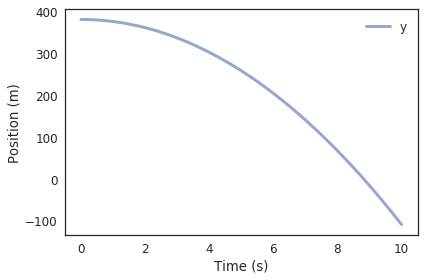

In [11]:
plot_position(results)
savefig('figs/chap09-fig01.pdf')

**Exercise:** Add a print statement to `slope_func` to print the value of `t` each time it's called.  What can we infer about how `odeint` works, based on the results?

In [12]:
# Solution

# It starts with small time steps and gradually makes them bigger.



**Exercise:** Change the value of `dt` and run the solver again.  What effect does it have on the results?

In [13]:
# Solution

# It has no effect on the results.  That's because `odeint` adjusts the
# time step to achieve the desired level of accuracy.

# After generating results with unequal time steps, it interpolates
# to get the values at the evenly-spaced `ts`.

### Onto the sidewalk

To figure out when the penny hit the sidewalk, we use `crossings`, which finds the times where a `Series` passes through a given value.

In [31]:
%psource crossings

def crossings(series, value):
    """Find the labels where the series passes through value.

    The labels in series must be increasing numerical values.

    series: Series
    value: number

    returns: sequence of labels
    """
    interp = InterpolatedUnivariateSpline(series.index, series-value)
    return interp.roots()


To figure out when the penny hit the sidewalk, we use `interp_inverse`, which return a function that maps from height to time.

In [32]:
t_crossings = crossings(results.y, 0)

array([8.81788535])

If `T` contains no elements, it means we haven't run the simulation long enough.

If it contains more than one element, we might have to figure out what that means.

But for this example, there should be just one, the time when the penny hits the sidewalk.

In [33]:
t_sidewalk = t_crossings[0]

8.817885349720566

We can compare that to the exact result.  Without air resistance, we have

$v = -g t$

and

$y = 381 - g t^2 / 2$

Setting $y=0$ and solving for $t$ yields

$t = \sqrt{\frac{2 y_{init}}{g}}$

In [34]:
sqrt(2 * init.y / g)

<Quantity(8.817885349720552, 'second')>

The estimate is accurate to about 10 decimal places.

We can double-check by running the simulation for the estimated flight time.

In [35]:
system.t_end = t_sidewalk
results, details = run_ode_solver(system, slope_func)

And checking the final state.

In [36]:
def final_state(results):
    """Returns the final position and velocity, with units.
    
    results: TimeFrame with y and v.
    
    returns: y, v at t_end
    """
    t_end = results.index[-1]
    y, v = results.loc[t_end]
    return y*m, v*m/s

As expected, the final height is close to 0.

In [37]:
y_final, v_final = final_state(results)
y_final

<Quantity(-9.094947017729282e-13, 'meter')>

And we can check the final velocity.

In [38]:
v_final

<Quantity(-86.41527642726155, 'meter / second')>

And convert to km/h

In [39]:
km = UNITS.kilometer
h = UNITS.hour
v_final.to(km / h)

<Quantity(-311.0949951381416, 'kilometer / hour')>

If there were no air resistance, the penny would hit the sidewalk (or someone's head) at more than 300 km/h.

So it's a good thing there is air resistance.

### Exercises

**Exercise:**

http://curious.astro.cornell.edu/about-us/39-our-solar-system/the-earth/other-catastrophes/57-how-long-would-it-take-the-earth-to-fall-into-the-sun-intermediate


In [41]:
N = UNITS.newton
kg = UNITS.kilogram
m = UNITS.meter
AU = UNITS.astronomical_unit

<Unit('astronomical_unit')>

In [42]:
r_0 = (1 * AU).to_base_units()
v_0 = 0 * m / s
init = State(r=r_0,
             v=v_0)

,values
r,149597870691.0 meter
v,0.0 meter / second


In [43]:
r_earth = 6.371e6 * m
r_sun = 695.508e6 * m

system = System(init=init,
                G=6.674e-11 * N / kg**2 * m**2,
                m1=1.989e30 * kg,
                r_final=r_sun + r_earth,
                m2=5.972e24 * kg,
                t_0=0 * s,
                t_end=1e7 * s)

,values
init,r 149597870691.0 meter v 0.0 meter / s...
G,6.674e-11 meter ** 2 * newton / kilogram ** 2
m1,1.989e+30 kilogram
r_final,701879000.0 meter
m2,5.972e+24 kilogram
t_0,0 second
t_end,10000000.0 second


In [44]:
def universal_gravitation(state, system):
    r, v = state
    unpack(system)
    
    force = G * m1 * m2 / r**2
    return force

In [45]:
universal_gravitation(init, system)

<Quantity(3.5423376937972604e+22, 'newton')>

In [46]:
def slope_func(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing `g`
    
    returns: derivatives of y and v
    """
    y, v = state
    unpack(system)    

    force = universal_gravitation(state, system)
    dydt = v
    dvdt = -force / m2
    
    return dydt, dvdt

In [47]:
slope_func(init, 0, system)

(<Quantity(0.0, 'meter / second')>,
 <Quantity(-0.005931576848287442, 'newton / kilogram')>)

In [48]:
def event_func(state, t, system):
    r, v = state
    return r - system.r_final

In [49]:
event_func(init, 0, system)

<Quantity(148895991691.0, 'meter')>

In [52]:
results, details = run_ode_solver(system, slope_func, events=event_func)

In [53]:
details

,values
message,A termination event occurred.
nfev,230
njev,0
nlu,0
sol,None
status,1
success,True
t_events,[[5577323.2573304195]]


In [54]:
t_event = details.t_events[0] * s

<Quantity([5577323.25733042], 'second')>

In [55]:
t_event.to(UNITS.day)

<Quantity([64.55235252], 'day')>

In [57]:
ts = linspace(t_0, t_event)
results, details = run_ode_solver(system, slope_func, events=event_func, t_eval=ts)

In [58]:
results.index /= 60 * 60 * 24

In [59]:
results['v']

,values


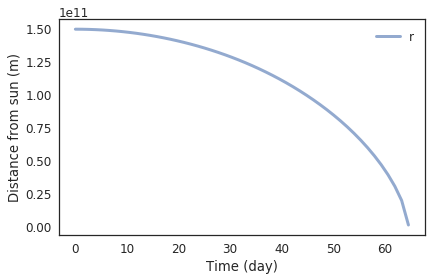

In [60]:
plot(results.r)

decorate(xlabel='Time (day)',
         ylabel='Distance from sun (m)')

### With air resistance

Next we'll add air resistance using the [drag equation](https://en.wikipedia.org/wiki/Drag_equation)

First I'll create a `Condition` object to contain the quantities we'll need.

In [ ]:
condition = Condition(height = 381 * m,
                      v_init = 0 * m / s,
                      g = 9.8 * m/s**2,
                      mass = 2.5e-3 * kg,
                      diameter = 19e-3 * m,
                      rho = 1.2 * kg/m**3,
                      v_term = 18 * m / s,
                      duration = 30 * s)

Now here's a version of `make_system` that takes a `Condition` object as a parameter.

`make_system` uses the given value of `v_term` to compute the drag coefficient `C_d`.

In [ ]:
def make_system(condition):
    """Makes a System object for the given conditions.
    
    condition: Condition with height, g, mass, diameter, 
               rho, v_term, and duration
    
    returns: System with init, g, mass, rho, C_d, area, and ts
    """
    unpack(condition)
    
    init = State(y=height, v=v_init)
    area = np.pi * (diameter/2)**2
    C_d = 2 * mass * g / (rho * area * v_term**2)
    ts = linspace(0, duration, 101)
    
    return System(init=init, g=g, mass=mass, rho=rho,
                  C_d=C_d, area=area, ts=ts)

Let's make a `System`

In [ ]:
system = make_system(condition)
system

Here's the slope function, including acceleration due to gravity and drag.

In [ ]:
def slope_func(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing g, rho,
            C_d, area, and mass
    
    returns: derivatives of y and v
    """
    y, v = state
    unpack(system)
    
    f_drag = rho * v**2 * C_d * area / 2
    a_drag = f_drag / mass
    
    dydt = v
    dvdt = -g + a_drag
    
    return dydt, dvdt

As always, let's test the slope function with the initial conditions.

In [ ]:
slope_func(system.init, 0, system)

And then run the simulation.

In [ ]:
run_odeint(system, slope_func)

First check that the simulation ran long enough for the penny to land.

In [ ]:
final_state(system.results)

Then compute the flight time.

In [ ]:
y = system.results.y
inverse = Series(y.index, index=y.values)
T = interpolate(inverse, kind='cubic')
T_sidewalk = T(0)
T_sidewalk

Setting the duration to the computed flight time, we can check the final conditions.

In [ ]:
condition.set(duration=T_sidewalk)
system = make_system(condition)
run_odeint(system, slope_func)
y_final, v_final = final_state(system.results)

The final height is close to 0, as expected.  And the final velocity is close to the given terminal velocity.

In [ ]:
y_final, v_final

Here's the plot of position as a function of time.

In [ ]:
plot_position(system.results)
savefig('chap09-fig02.pdf')

And velocity as a function of time:

In [ ]:
def plot_velocity(results):
    """Plot the results.
    
    results: DataFrame with velocity, v
    """
    newfig()
    plot(results.v, label='v')
        
    decorate(xlabel='Time (s)',
             ylabel='Velocity (m/2)')

In [ ]:
plot_velocity(system.results)

From an initial velocity of 0, the penny accelerates downward until it reaches terminal velocity; after that, velocity is constant.

**Exercise:** Run the simulation with an initial velocity, downward, that exceeds the penny's terminal velocity.  Hint: use `condition.set`.

What do you expect to happen?  Plot velocity and position as a function of time, and see if they are consistent with your prediction.

In [ ]:
# Solution

condition.set(v_init = -30 * m / s)
system = make_system(condition)
run_odeint(system, slope_func)
plot_position(system.results)

In [ ]:
# Solution

plot_velocity(system.results)

### Dropping quarters

Suppose we drop a quarter from the Empire State Building and find that its flight time is 19.1 seconds.  We can use this measurement to estimate the coefficient of drag.

Here's a `Condition` object with the relevant parameters from
https://en.wikipedia.org/wiki/Quarter_(United_States_coin)


In [ ]:
condition = Condition(height = 381 * m,
                      v_init = 0 * m / s,
                      g = 9.8 * m/s**2,
                      mass = 5.67e-3 * kg,
                      diameter = 24.26e-3 * m,
                      rho = 1.2 * kg/m**3,
                      duration = 19.1 * s)

And here's a modified version of `make_system`

In [ ]:
def make_system(condition):
    """Makes a System object for the given conditions.
    
    condition: Condition with height, v_init, g, mass, diameter, 
               rho, C_d, and duration
    
    returns: System with init, g, mass, rho, C_d, area, and ts
    """
    unpack(condition)
    
    init = State(y=height, v=v_init)
    area = np.pi * (diameter/2)**2
    ts = linspace(0, duration, 101)
    
    return System(init=init, g=g, mass=mass, rho=rho,
                  C_d=C_d, area=area, ts=ts)

We can run the simulation with an initial guess of `C_d=0.4`.

In [ ]:
condition.set(C_d=0.4)
system = make_system(condition)
run_odeint(system, slope_func)
plot_position(system.results)

The final height is -11 meters, which means our guess was too low (we need more drag to slow the quarter down).

In [ ]:
final_state(system.results)

`height_func` takes a hypothetical value of `C_d` and returns the height after 19.1 seconds.

In [ ]:
def height_func(C_d, condition):
    """Final height as a function of C_d.
    
    C_d: drag coefficient
    condition: Condition object
    
    returns: height in m
    """
    condition.set(C_d=C_d)
    system = make_system(condition)
    run_odeint(system, slope_func)
    y, v = final_state(system.results)
    return y

If we run it with `C_d=0.4`, we get -11 meters again.

In [ ]:
height_func(0.4, condition)

Now we can use `fsolve` to find the value of `C_d` that makes the final height 0.

In [ ]:
solution = fsolve(height_func, 0.4, condition)
solution

Plugging in the estimated value, we can run the simulation again to get terminal velocity.

In [ ]:
condition.set(C_d=solution)
system = make_system(condition)
run_odeint(system, slope_func)
final_state(system.results)

In this example, the terminal velocity of the quarter is higher than that of the penny, but we should not take this result seriously because the measurements we used are not real; I made them up.